Научить U-net удалять водяные знаки с изображений. Используется CelebFaces Dataset. 

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import cv2
from tqdm import tqdm
import urllib.request
import requests
tqdm.pandas()
import random
from PIL import Image
import matplotlib.pyplot as plt


In [2]:
import pickle

In [3]:
def seed_everything(seed=51):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=51)

In [4]:
ROOT_PATH = os.path.abspath(os.curdir)
DATA_PATH = os.path.join(ROOT_PATH,'img_align_celeba')

In [5]:
HOW_MANY_EXIST = len(os.listdir(os.path.join(ROOT_PATH,'img_align_celeba')))
HOW_MANY_CHOOSE = 5000
CHOSEN_INDEXES = np.random.choice(HOW_MANY_EXIST,HOW_MANY_CHOOSE)
IMG_SIZE = 256

In [6]:
ALL_NAMES = os.listdir(os.path.join(ROOT_PATH,'img_align_celeba'))
READ_PICTURE_NAMES = [ALL_NAMES[x] for x in CHOSEN_INDEXES]

In [7]:
def create_target():
    target_data = []
    for img in tqdm(READ_PICTURE_NAMES):
        path = os.path.join('./img_align_celeba',img)
        img = cv2.imread(path,1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        target_data.append(img)
    return target_data

In [8]:
target_data=create_target()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:01<00:00, 40.99it/s]


In [9]:
def get_words():
    word_url = "https://random-word-api.herokuapp.com/all"
    response = urllib.request.urlopen(word_url)
    long_txt = response.read().decode().split(',')
    return long_txt

In [10]:
words = get_words()
print(words[1])

"abreacted"


In [11]:
print(words[67])

"absences"


In [12]:
x_coors = list(range(0,128,1))
y_coors = list(range(32,256,1))
font_faces = [0,1,2,3,4,5,6,7,16]
font_scales = [1.5,2.0,2.5]
colors = [(0,0,0),(255,255,255)]
bolds = [1,2,3]

In [13]:
def create_input():
    input_data = []
    for img in tqdm(target_data):
        used_text = random.choice(words)
        x_coor = random.choice(x_coors)
        y_coor = random.choice(y_coors)
        font_face = random.choice(font_faces)
        font_scale = random.choice(font_scales)
        color = random.choice(colors)
        bold = random.choice(bolds)
        
        texted_image =cv2.putText(img=np.copy(img),
                                  text=used_text,
                                  org=(x_coor,y_coor),
                                  fontFace=font_face,
                                  fontScale=font_scale,
                                  color=color,
                                  thickness=bold)
        input_data.append(texted_image)
    return input_data

In [14]:
input_data=create_input()

100%|████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5063.91it/s]


In [92]:
print(input_data[0])

[[[ 17  16  12]
  [ 17  16  12]
  [ 18  17  13]
  ...
  [ 71  70  66]
  [ 59  58  53]
  [ 51  50  45]]

 [[ 16  15  11]
  [ 17  16  12]
  [ 17  16  12]
  ...
  [ 68  68  63]
  [ 56  55  50]
  [ 49  48  43]]

 [[ 15  14  10]
  [ 16  15  11]
  [ 16  15  11]
  ...
  [ 65  64  60]
  [ 52  51  47]
  [ 45  44  39]]

 ...

 [[240 206 219]
  [238 204 216]
  [237 203 215]
  ...
  [ 55  55  56]
  [ 58  58  56]
  [ 58  58  56]]

 [[241 205 216]
  [242 205 217]
  [242 206 218]
  ...
  [ 49  49  49]
  [ 50  50  49]
  [ 50  50  48]]

 [[242 204 215]
  [243 204 215]
  [243 206 217]
  ...
  [ 42  42  43]
  [ 42  42  41]
  [ 42  42  40]]]


In [15]:
from tensorflow.keras.layers import Input,Conv2D,Lambda,Dropout,MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [16]:
WIDTH = 256
HEIGHT = 256
CHANNELS = 3
#Model Parameters
EPOCHS = 10
BATCH_SIZE = 16

USE_TENSORBOARD = True

In [17]:
input_shape = (WIDTH,HEIGHT,CHANNELS)

In [18]:
def get_model(input_shape = input_shape,compiling=True):
    """
    Defining a Unet Architecture
    """
    ##Contraction Path##
    inputs = Input(input_shape)
    #Lambda
    scaled = tf.keras.layers.Lambda(lambda x: x/255)(inputs)
    #Conv1
    conv1 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(scaled)
    conv1 = Dropout(0.2)(conv1)
    conv1 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv1)
    pool1 = MaxPooling2D((2,2))(conv1)
    #Conv2
    conv2 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool1)
    conv2 = Dropout(0.2)(conv2)
    conv2 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv2)
    pool2 = MaxPooling2D((2,2))(conv2)
    #Conv3
    conv3 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool2)
    conv3 = Dropout(0.2)(conv3)
    conv3 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv3)
    pool3 = MaxPooling2D((2,2))(conv3)
    #Conv4
    conv4 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool3)
    conv4 = Dropout(0.2)(conv4)
    conv4 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv4)
    pool4 = MaxPooling2D((2,2))(conv4)
    #Conv5
    conv5 = Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(pool4)
    conv5 = Dropout(0.2)(conv5)
    conv5 = Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv5)
    ##Expansive Path##

    #Conv6
    conv6_up = Conv2DTranspose(128,(2,2),strides = (2,2),padding='same')(conv5)
    conv6_up = concatenate([conv6_up,conv4])
    conv6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv6_up)
    conv6 = Dropout(0.2)(conv6)
    conv6 = Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv6)

    #Conv7
    conv7_up = Conv2DTranspose(64,(2,2),strides = (2,2),padding='same')(conv6)
    conv7_up = concatenate([conv7_up,conv3])
    conv7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv7_up)
    conv7 = Dropout(0.2)(conv7)
    conv7 = Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv7)

    #Conv8
    conv8_up = Conv2DTranspose(32,(2,2),strides = (2,2),padding='same')(conv7)
    conv8_up = concatenate([conv8_up,conv2])
    conv8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv8_up)
    conv8 = Dropout(0.2)(conv8)
    conv8 = Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv8)

    #Conv9
    conv9_up = Conv2DTranspose(16,(2,2),strides = (2,2),padding='same')(conv8)
    conv9_up = concatenate([conv9_up,conv1])
    conv9 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv9_up)
    conv9 = Dropout(0.2)(conv9)
    conv9 = Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv9)

    #Output Layer
    outputs = Conv2D(3,(1,1),activation='sigmoid')(conv9)

    #Lambda
    outputs_scaled = tf.keras.layers.Lambda(lambda x: x*255)(outputs)

    #Model
    adam = Adam(learning_rate = 3e-4)
    model = Model(inputs= [inputs],outputs = [outputs_scaled])
    if compiling:
        model.compile(optimizer = adam, loss = 'mean_squared_error',metrics = [tf.keras.metrics.MeanSquaredError()])
    return model

In [19]:
model = get_model(input_shape,compiling=True)

In [21]:
target_data,input_data

([array([[[218, 217, 222],
          [222, 221, 226],
          [226, 225, 230],
          ...,
          [236, 236, 236],
          [236, 236, 236],
          [236, 236, 236]],
  
         [[220, 219, 224],
          [224, 223, 228],
          [228, 227, 232],
          ...,
          [236, 236, 236],
          [236, 236, 236],
          [236, 236, 236]],
  
         [[217, 216, 219],
          [221, 221, 224],
          [226, 226, 229],
          ...,
          [236, 236, 236],
          [236, 236, 236],
          [236, 236, 236]],
  
         ...,
  
         [[242, 236, 240],
          [242, 237, 238],
          [242, 236, 237],
          ...,
          [ 78,  56,  33],
          [ 75,  54,  30],
          [ 74,  54,  30]],
  
         [[243, 238, 239],
          [244, 238, 238],
          [245, 237, 237],
          ...,
          [ 66,  45,  22],
          [ 67,  47,  23],
          [ 68,  48,  24]],
  
         [[239, 233, 233],
          [240, 233, 232],
          [240, 231, 230

In [21]:
tar_data=np.asarray(target_data)

In [22]:
inp_data=np.asarray(input_data)

In [23]:
X_test = input_data[4000:]
y_test = target_data[4000:]

In [24]:
X_train, X_val, y_train, y_val = train_test_split(inp_data,tar_data, test_size=0.20, random_state=42)

In [26]:
X_trainScale, y_trainScale = X_train / 255.0, y_train / 255.0

In [27]:
X_trainScale[0]

array([[[0.34901961, 0.22745098, 0.10588235],
        [0.3254902 , 0.20392157, 0.08235294],
        [0.32156863, 0.2       , 0.07843137],
        ...,
        [0.51372549, 0.42352941, 0.30588235],
        [0.52156863, 0.41960784, 0.30588235],
        [0.5254902 , 0.41960784, 0.30588235]],

       [[0.34901961, 0.22745098, 0.10588235],
        [0.32941176, 0.20784314, 0.08627451],
        [0.32156863, 0.20392157, 0.07843137],
        ...,
        [0.51372549, 0.42745098, 0.30588235],
        [0.52156863, 0.41960784, 0.30588235],
        [0.5254902 , 0.41960784, 0.30588235]],

       [[0.34901961, 0.22745098, 0.10588235],
        [0.32941176, 0.20784314, 0.08627451],
        [0.32156863, 0.20392157, 0.08235294],
        ...,
        [0.52156863, 0.43137255, 0.30980392],
        [0.5254902 , 0.42352941, 0.30588235],
        [0.5254902 , 0.41960784, 0.30588235]],

       ...,

       [[0.39215686, 0.43137255, 0.47058824],
        [0.39215686, 0.43137255, 0.47058824],
        [0.39215686, 0

In [105]:
#Провести аугаментацию изображений
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(rotation_range=45.,
                         width_shift_range=0.1,
                         height_shift_range=0.1,
                         shear_range=0.2,
                         zoom_range=0.2,
                         horizontal_flip=True,
                         vertical_flip=True,
                         fill_mode='reflect')

X_datagen = ImageDataGenerator(**data_gen_args)
Y_datagen = ImageDataGenerator(**data_gen_args)
test_datagen = ImageDataGenerator()
X_datagen_val = ImageDataGenerator()
Y_datagen_val = ImageDataGenerator()

X_datagen.fit(X_train, augment=True, seed=13)
Y_datagen.fit(y_train, augment=True, seed=13)
test_datagen.fit(X_val, augment=True, seed=13)
X_datagen_val.fit(X_val, augment=True, seed=13)
Y_datagen_val.fit(y_val, augment=True, seed=13)

X_train_augmented = X_datagen.flow(X_train,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented = Y_datagen.flow(y_train,  batch_size=15, shuffle=True, seed=13)
test_augmented = test_datagen.flow(X_val, shuffle=False, seed=13)
X_train_augmented_val = X_datagen_val.flow(X_val,  batch_size=15, shuffle=True, seed=13)
Y_train_augmented_val = Y_datagen_val.flow(y_val,  batch_size=15, shuffle=True, seed=13)

train_generator = zip(X_train_augmented, Y_train_augmented)
val_generator = zip(X_train_augmented_val, Y_train_augmented_val)

In [110]:
tf.keras.backend.clear_session()

In [28]:
if USE_TENSORBOARD:
    checkpoint = ModelCheckpoint('model_epoch_{}.h5'.format(EPOCHS),verbose=1,save_best_only=True)
    early_stopping = EarlyStopping(patience=3,monitor='val_loss')
    tensorboard = TensorBoard(log_dir='../logs')
    callbacks = [checkpoint,early_stopping,tensorboard]
else:
    checkpoint = ModelCheckpoint('model_epoch_{}.h5'.format(EPOCHS),verbose=1,save_best_only=True)
    early_stopping = EarlyStopping(patience=3,monitor='val_loss')
    callbacks = [checkpoint,early_stopping]

In [128]:
history = model.fit(x = X_trainScale, y = y_trainScale,batch_size=BATCH_SIZE,epochs=EPOCHS,\
          verbose=1,validation_data=(X_val,y_val),callbacks=callbacks)

Epoch 1/10
250/250 [==============================] - ETA: 0s - loss: 0.2951 - mean_squared_error: 0.2951
Epoch 1: val_loss improved from 348.78146 to 271.28302, saving model to model_epoch_10.h5
250/250 [==============================] - 2577s 10s/step - loss: 0.2951 - mean_squared_error: 0.2951 - val_loss: 271.2830 - val_mean_squared_error: 271.2830
Epoch 2/10
250/250 [==============================] - ETA: 0s - loss: 0.2828 - mean_squared_error: 0.2828
Epoch 2: val_loss did not improve from 271.28302
250/250 [==============================] - 1465s 6s/step - loss: 0.2828 - mean_squared_error: 0.2828 - val_loss: 273.5418 - val_mean_squared_error: 273.5418
Epoch 3/10
250/250 [==============================] - ETA: 0s - loss: 0.2821 - mean_squared_error: 0.2821
Epoch 3: val_loss did not improve from 271.28302
250/250 [==============================] - 1477s 6s/step - loss: 0.2821 - mean_squared_error: 0.2821 - val_loss: 275.3655 - val_mean_squared_error: 275.3655
Epoch 4/10
250/250 [==

In [129]:
predict = model.predict(X_val)

32/32 [==============================] - 53s 2s/step


Попробовать PCA и L2 регуляризацию.

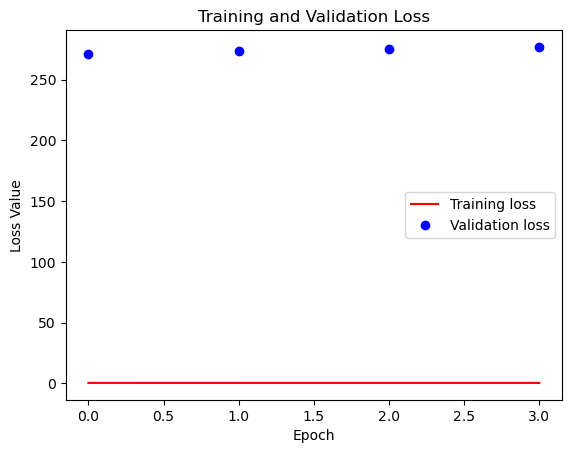

In [130]:
loss = history3.history['loss']
val_loss = history3.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

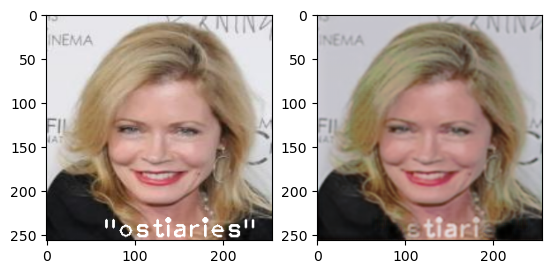

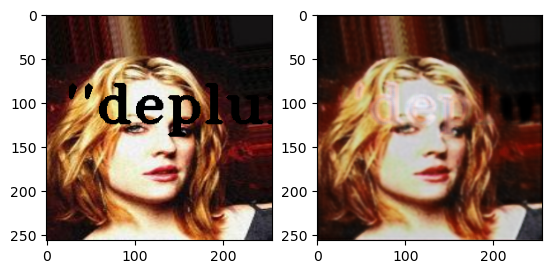

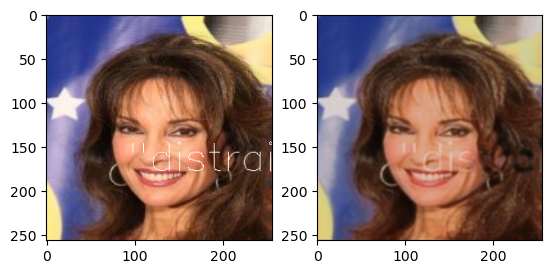

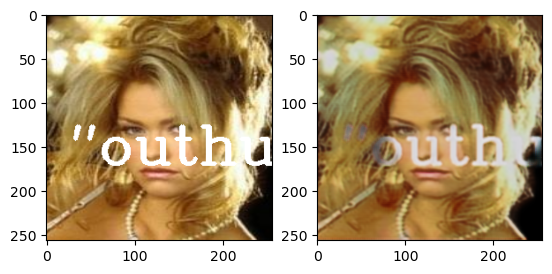

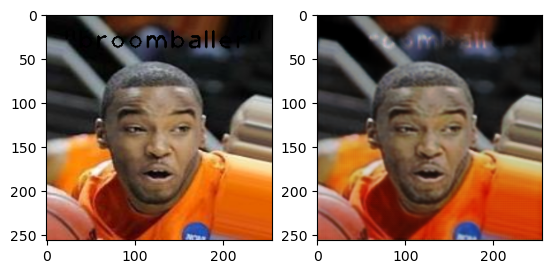

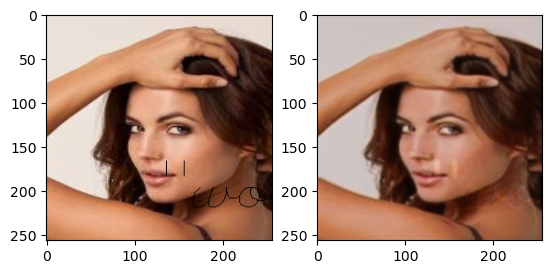

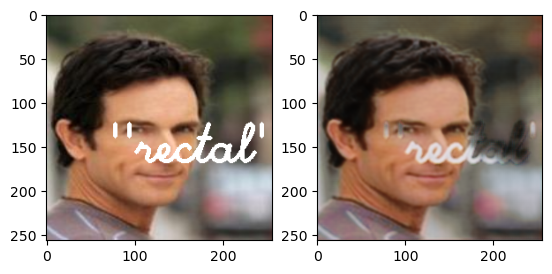

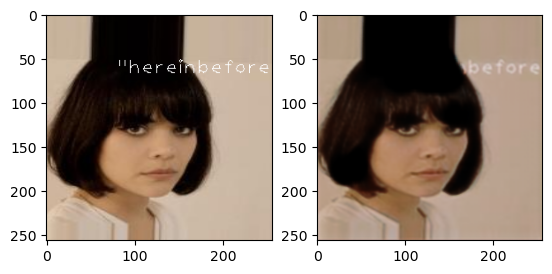

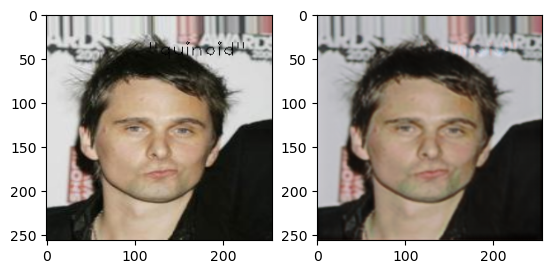

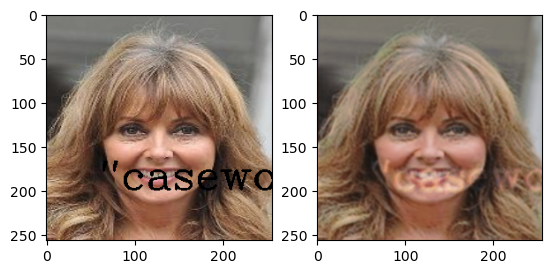

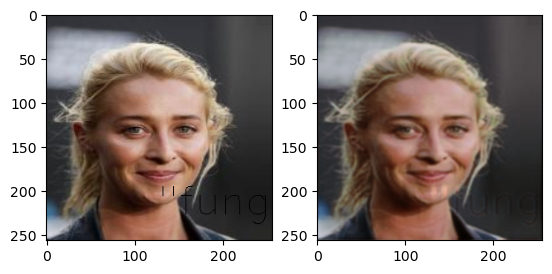

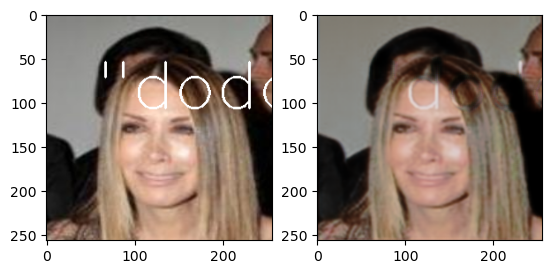

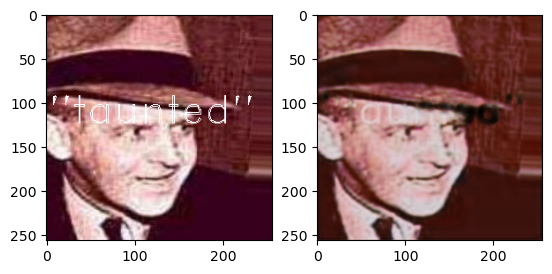

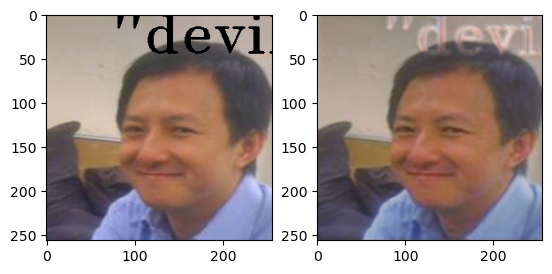

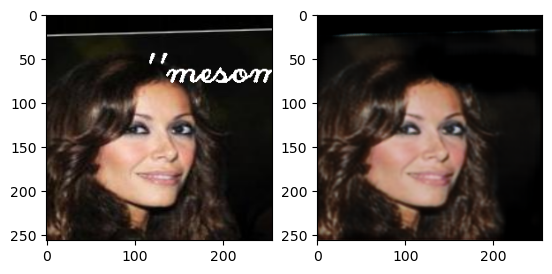

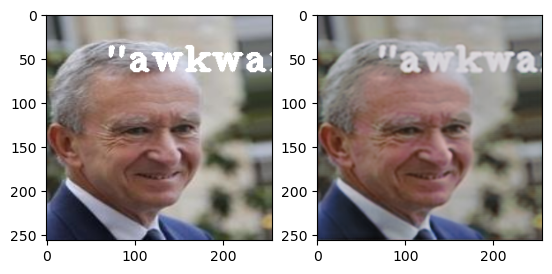

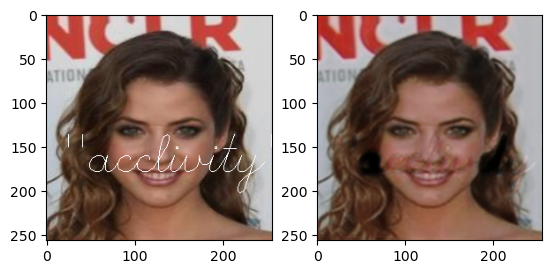

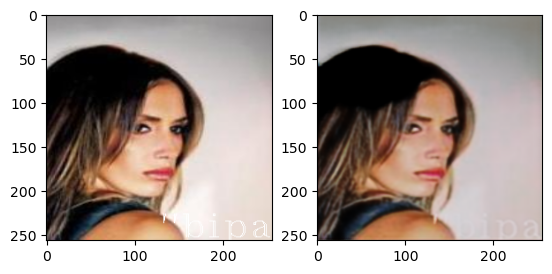

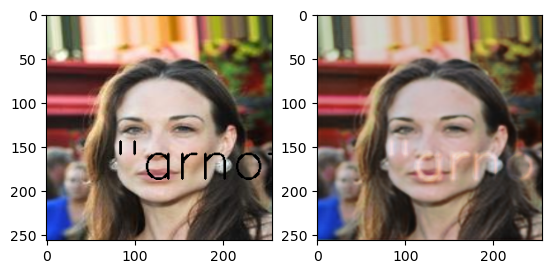

In [131]:
for image_no in range(1,20,1):
    plt.subplot(1, 2, 1)
    plt.imshow(X_val[image_no].astype('uint8'))
    plt.subplot(1, 2, 2)
    plt.imshow(predict[image_no].astype('uint8'))
    plt.show()